In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [4]:
chunksize = 5 * 10 ** 5
filename = 'matches_small.csv'
print(pd.read_csv(filename, nrows=5))

     match_id  match_seq_num radiant_win  start_time  duration  \
0  2304340261     2019317886           t  1461013929      1701   
1  2304335744     2019317899           t  1461013382      2299   
2  2304324185     2019317908           t  1461012679      3291   
3  2304339409     2019317931           f  1461013865      2192   
4  2304329004     2019317805           t  1461012987      2989   

   tower_status_radiant  tower_status_dire  barracks_status_radiant  \
0                  1975                  4                       63   
1                  1983                  0                       63   
2                  1584                  0                       60   
3                     0               1982                        0   
4                     4                  0                        3   

   barracks_status_dire  cluster  ...  engine  picks_bans  parse_status  chat  \
0                     3      155  ...       1         NaN             3   NaN   
1             

In [7]:
#run this once to create database
chunksize = 5 * 10 ** 5
filename = 'matches_small.csv'
csv_database = create_engine('sqlite:///csv_database.db')
for chunk in pd.read_csv(filename, chunksize=chunksize):
    i = 0
    j = 1
    for df in pd.read_csv(filename, chunksize=chunksize, iterator=True):
          df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
          df.index += j
          i+=1
          df.to_sql('table', csv_database, if_exists='append')
          j = df.index[-1] + 1

In [2]:
#run this every time
csv_database = create_engine('sqlite:///csv_database.db')
df = pd.read_sql_query("SELECT * FROM 'table'LIMIT 1000000", csv_database)

In [3]:
for col in df.columns: 
    print(col) 
df.shape

index
match_id
match_seq_num
radiant_win
start_time
duration
tower_status_radiant
tower_status_dire
barracks_status_radiant
barracks_status_dire
cluster
first_blood_time
lobby_type
human_players
leagueid
positive_votes
negative_votes
game_mode
engine
picks_bans
parse_status
chat
objectives
radiant_gold_adv
radiant_xp_adv
teamfights
version
pgroup


(1000000, 28)

In [3]:
#cleaning out columns that aren't needed or complicated
# website as reference https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status
df = df.drop(['index'], axis=1)
df = df.drop(['match_id'], axis=1) #match id isn't useful for this type of data
df =df.drop(['match_seq_num'], axis=1) #match_seq_num isn't important
#radiant_win is used for victory (what we use to predict)
df = df.drop(['start_time'], axis=1) #seems random
#duration seems useful
df = df.drop(["cluster"],axis=1) #not important
df = df.drop(["leagueid"],axis=1) #not important 
df = df.drop(["positive_votes"],axis=1) #not important
df = df.drop(["negative_votes"],axis=1) #not important
df = df.drop(["engine"],axis=1) #not important
df = df.drop(["parse_status"],axis=1) #not important
df = df.drop(["chat"],axis=1) #not important
df = df.drop(["objectives"],axis=1) #other things can represent this, such as tower status and barracks status
df = df.drop(["version"],axis=1) # not important
df = df.drop(["pgroup"],axis=1) # not important

df = df.drop(["picks_bans"],axis=1) #pick_bans seems complicated (does hero order and all that)

In [5]:
for col in df.columns: 
    print(col) 
df.shape
df

radiant_win
duration
tower_status_radiant
tower_status_dire
barracks_status_radiant
barracks_status_dire
first_blood_time
lobby_type
human_players
game_mode
radiant_gold_adv
radiant_xp_adv
teamfights


,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,first_blood_time,lobby_type,human_players,game_mode,radiant_gold_adv,radiant_xp_adv,teamfights
0,t,1701,1975,4,63,3,100,0,10,1,None,None,None
1,t,2299,1983,0,63,0,127,0,10,18,None,None,None
2,t,3291,1584,0,60,0,196,0,10,1,None,None,None
3,f,2192,0,1982,0,63,44,0,10,5,None,None,None
4,t,2989,4,0,3,48,104,0,10,1,None,None,None
5,f,2586,0,2046,0,63,111,0,10,1,None,None,None
6,t,2759,1974,260,63,51,142,0,10,4,None,None,None
7,t,1485,2046,4,63,3,138,7,10,22,None,None,None
8,t,2734,1972,0,63,0,320,0,10,1,None,None,None
9,f,3500,0,1958,0,63,10,7,10,22,None,None,None


In [4]:
#radiant tower status
radiant_ancient_bottom = [] 
radiant_ancient_top = [] 
radiant_bot_tier3 = [] 
radiant_bot_tier2  = [] 
radiant_bot_tier1  = [] 
radiant_mid_tier3 = [] 
radiant_mid_tier2  = [] 
radiant_mid_tier1  = [] 
radiant_top_tier3 = [] 
radiant_top_tier2  = [] 
radiant_top_tier1  = [] 

for z in df["tower_status_radiant"]:
    element = format(z,"016b")
    if element[5]=='1':
        radiant_ancient_bottom.append(1)
    else:
        radiant_ancient_bottom.append(0)
    if element[6]=='1':
        radiant_ancient_top.append(1)
    else:
        radiant_ancient_top.append(0)
    if element[7]=='1':
        radiant_bot_tier3.append(1)
    else:
        radiant_bot_tier3.append(0)
    if element[8]=='1':
        radiant_bot_tier2.append(1)
    else:
        radiant_bot_tier2.append(0) 
    if element[9]=='1':
        radiant_bot_tier1.append(1)
    else:
        radiant_bot_tier1.append(0) 
    if element[10]=='1':
        radiant_mid_tier3.append(1)
    else:
        radiant_mid_tier3.append(0) 
    if element[11]=='1':
        radiant_mid_tier2.append(1)
    else:
        radiant_mid_tier2.append(0)
    if element[12]=='1':
        radiant_mid_tier1.append(1)
    else:
        radiant_mid_tier1.append(0)
    if element[13]=='1':
        radiant_top_tier3.append(1)
    else:
        radiant_top_tier3.append(0)
    if element[14]=='1':
        radiant_top_tier2.append(1)
    else:
        radiant_top_tier2.append(0)
    if element[15]=='1':
        radiant_top_tier1.append(1)
    else:
        radiant_top_tier1.append(0)

df["radiant_ancient_bottom"] = radiant_ancient_bottom 
df["radiant_ancient_top"] = radiant_ancient_top 
df["radiant_bot_tier3"] = radiant_bot_tier3 
df["radiant_bot_tier2"] = radiant_bot_tier2  
df["radiant_bot_tier1"] = radiant_bot_tier1   
df["radiant_mid_tier3"] = radiant_mid_tier3  
df["radiant_mid_tier2"] = radiant_mid_tier2   
df["radiant_mid_tier1"] = radiant_mid_tier1  
df["radiant_top_tier3"] = radiant_top_tier3 
df["radiant_top_tier2"] =radiant_top_tier2  
df["radiant_top_tier1"] =radiant_top_tier1  

In [5]:
#dire tower status
dire_ancient_bottom = [] 
dire_ancient_top = [] 
dire_bot_tier3 = [] 
dire_bot_tier2  = [] 
dire_bot_tier1  = [] 
dire_mid_tier3 = [] 
dire_mid_tier2  = [] 
dire_mid_tier1  = [] 
dire_top_tier3 = [] 
dire_top_tier2  = [] 
dire_top_tier1  = [] 

for z in df["tower_status_dire"]:
    element = format(z,"016b")
    if element[5]=='1':
        dire_ancient_bottom.append(1)
    else:
        dire_ancient_bottom.append(0)
    if element[6]=='1':
        dire_ancient_top.append(1)
    else:
        dire_ancient_top.append(0)
    if element[7]=='1':
        dire_bot_tier3.append(1)
    else:
        dire_bot_tier3.append(0)
    if element[8]=='1':
        dire_bot_tier2.append(1)
    else:
        dire_bot_tier2.append(0) 
    if element[9]=='1':
        dire_bot_tier1.append(1)
    else:
        dire_bot_tier1.append(0) 
    if element[10]=='1':
        dire_mid_tier3.append(1)
    else:
        dire_mid_tier3.append(0) 
    if element[11]=='1':
        dire_mid_tier2.append(1)
    else:
        dire_mid_tier2.append(0)
    if element[12]=='1':
        dire_mid_tier1.append(1)
    else:
        dire_mid_tier1.append(0)
    if element[13]=='1':
        dire_top_tier3.append(1)
    else:
        dire_top_tier3.append(0)
    if element[14]=='1':
        dire_top_tier2.append(1)
    else:
        dire_top_tier2.append(0)
    if element[15]=='1':
        dire_top_tier1.append(1)
    else:
        dire_top_tier1.append(0)

df["dire_ancient_bottom"] = dire_ancient_bottom 
df["dire_ancient_top"] = dire_ancient_top 
df["dire_bot_tier3"] = dire_bot_tier3 
df["dire_bot_tier2"] = dire_bot_tier2  
df["dire_bot_tier1"] = dire_bot_tier1   
df["dire_mid_tier3"] = dire_mid_tier3 
df["dire_mid_tier2"] = dire_mid_tier2   
df["dire_mid_tier1"] = dire_mid_tier1  
df["dire_top_tier3"] = dire_top_tier3 
df["dire_top_tier2"] = dire_top_tier2  
df["dire_top_tier1"] = dire_top_tier1  

In [6]:
#dire barracks
dire_bot_ranged = [] 
dire_bot_melee = [] 
dire_mid_ranged = [] 
dire_mid_melee  = [] 
dire_top_ranged  = [] 
dire_top_melee = [] 


for z in df["barracks_status_dire"]:
    element = format(z,"08b")
    if element[2]=='1':
        dire_bot_ranged.append(1)
    else:
        dire_bot_ranged.append(0)
    if element[3]=='1':
        dire_bot_melee.append(1)
    else:
        dire_bot_melee.append(0)
    if element[4]=='1':
        dire_mid_ranged.append(1)
    else:
        dire_mid_ranged.append(0)
    if element[5]=='1':
        dire_mid_melee.append(1)
    else:
        dire_mid_melee.append(0) 
    if element[6]=='1':
        dire_top_ranged.append(1)
    else:
        dire_top_ranged.append(0) 
    if element[7]=='1':
        dire_top_melee.append(1)
    else:
        dire_top_melee.append(0) 

df["dire_bot_ranged"] = dire_bot_ranged 
df["dire_bot_melee"] = dire_bot_melee  
df["dire_mid_ranged"] = dire_mid_ranged 
df["dire_mid_melee"] = dire_mid_melee 
df["dire_top_ranged"] = dire_top_ranged  
df["dire_top_melee"] = dire_top_melee 


In [7]:
#radiant barracks
radiant_bot_ranged = [] 
radiant_bot_melee = [] 
radiant_mid_ranged = [] 
radiant_mid_melee  = [] 
radiant_top_ranged  = [] 
radiant_top_melee = [] 


for z in df["barracks_status_radiant"]:
    element = format(z,"08b")
    if element[2]=='1':
        radiant_bot_ranged.append(1)
    else:
        radiant_bot_ranged.append(0)
    if element[3]=='1':
        radiant_bot_melee.append(1)
    else:
        radiant_bot_melee.append(0)
    if element[4]=='1':
        radiant_mid_ranged.append(1)
    else:
        radiant_mid_ranged.append(0)
    if element[5]=='1':
        radiant_mid_melee.append(1)
    else:
        radiant_mid_melee.append(0) 
    if element[6]=='1':
        radiant_top_ranged.append(1)
    else:
        radiant_top_ranged.append(0) 
    if element[7]=='1':
        radiant_top_melee.append(1)
    else:
        radiant_top_melee.append(0) 

df["radiant_bot_ranged"] = radiant_bot_ranged 
df["radiant_bot_melee"] = radiant_bot_melee  
df["radiant_mid_ranged"] = radiant_mid_ranged 
df["radiant_mid_melee"] = radiant_mid_melee 
df["radiant_top_ranged"] = radiant_top_ranged  
df["radiant_top_melee"] = radiant_top_melee 


In [8]:
#reformating
#some values from this website https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status

rdf = df
#converting radiant win binary 
rdf['radiant_win'] = rdf['radiant_win'].replace('t', 1)
rdf['radiant_win'] = rdf['radiant_win'].replace('f', 0)

#keeping it exclusively ranked matches
rdf = rdf[rdf["lobby_type"] == 7]
rdf = rdf[rdf["game_mode"] == 22]

#making sure there's no "NaN"
rdf = rdf.dropna(subset=['teamfights', 'radiant_gold_adv','radiant_xp_adv'])

rdf = rdf.drop("tower_status_radiant",axis=1)
rdf = rdf.drop("tower_status_dire",axis=1)

print(rdf.shape)
print(rdf)

(3887, 45)
        radiant_win  duration  barracks_status_radiant  barracks_status_dire  \
299               0      1374                        0                    63   
420               1      3208                       63                     3   
421               0      2638                        0                    63   
422               0      2953                        3                    63   
832               1      1956                       63                     3   
1380              0      3082                        0                    63   
2314              0      1723                        0                    63   
2315              0      1320                       48                    63   
2316              1      2914                       55                     3   
2571              0      2325                        0                    63   
2588              1      2016                       63                     0   
2652              0      2154

[3887 rows x 45 columns]


In [9]:
#for cleaning that takes a while

#replacing gold_adv array to last element of array (what they end up getting at the end of the game)
for x in rdf['radiant_gold_adv']:
    text = x
    text = text.replace('{', '')
    text = text.replace('}', '')
    text = text.split(',')
    element = int(text[-1])
    index = (rdf['radiant_gold_adv']==x).idxmax()
    rdf['radiant_gold_adv'][index] = element

#replacing xp_adv array to last element of array (what they end up getting at the end of the game)
for x in rdf['radiant_xp_adv']:
    text = x
    text = text.replace('{', '')
    text = text.replace('}', '')
    text = text.split(',')
    element = int(text[-1])
    index = (rdf['radiant_xp_adv']==x).idxmax()
    rdf['radiant_xp_adv'][index] = element

C:\Users\aegis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\aegis\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
#teamfights might change it to number of teamfights
for x in rdf['teamfights']:
    text = x
    text = text.split('"start')
    element = len(text)
    index = (rdf['teamfights']==x).idxmax()
    rdf['teamfights'][index] = element

C:\Users\aegis\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [11]:
rdf = rdf.drop("lobby_type", axis=1)
rdf = rdf.drop("game_mode", axis=1)
rdf = rdf.drop("barracks_status_radiant",axis=1)
rdf = rdf.drop("barracks_status_dire",axis=1)

In [83]:
#model 1 include all the columns
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics
import statistics as stats


col_names = list(rdf.columns)
col_names.remove('radiant_win')
X = rdf[col_names]
y = rdf['radiant_win']

#normalize X values
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y= y.to_numpy()


mses = []
cfs =[]
accuracy = []

cv = KFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    diff = y_pred - y_test
    mse = (np.dot(diff, diff))/len(diff)
    mses.append(mse)
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cfs.append(cnf_matrix)
    accuracy.append(metrics.accuracy_score(y_test, y_pred))

C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [48]:
print("Average MSE for Model 1: ", stats.mean(mses))
print("Average accuracy for Model 1: ",stats.mean(accuracy))

Average MSE for Model 1:  0.007203898720608232
Average accuracy for Model 1:  0.9927961012793918


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cfs[0]), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

In [15]:
#model 2 include objectives only
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics
import statistics as stats


col_names = list(rdf.columns)
col_names.remove('duration')
col_names.remove('radiant_win')
col_names.remove('first_blood_time')
col_names.remove('human_players')
col_names.remove('radiant_gold_adv')
col_names.remove('radiant_xp_adv')
col_names.remove('teamfights')
X = rdf[col_names]
y = rdf['radiant_win']

#normalize X values
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y= y.to_numpy()


mses = []
cfs =[]
accuracy = []

cv = KFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    diff = y_pred - y_test
    mse = (np.dot(diff, diff))/len(diff)
    mses.append(mse)
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cfs.append(cnf_matrix)
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    


C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [16]:
print("Average MSE for Model 2: ", stats.mean(mses))
print("Average accuracy for Model 2: ",stats.mean(accuracy))

Average MSE for Model 2:  0.008233499750209261
Average accuracy for Model 2:  0.9917665002497907


Text(0.5, 257.44, 'Predicted label')

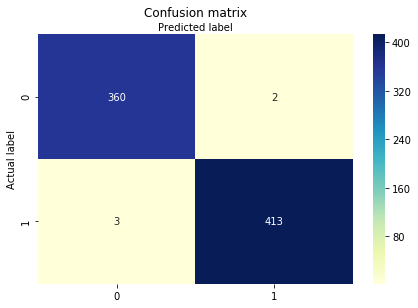

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cfs[0]), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [18]:
#model 3 include non-objectives
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics
import statistics as stats


col_names = list(rdf.columns)
col_names = ['duration','first_blood_time','human_players','radiant_gold_adv', 'radiant_xp_adv','teamfights']
X = rdf[col_names]
y = rdf['radiant_win']

#normalize X values
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y= y.to_numpy()


mses = []
cfs =[]
accuracy = []

cv = KFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    diff = y_pred - y_test
    mse = (np.dot(diff, diff))/len(diff)
    mses.append(mse)
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cfs.append(cnf_matrix)
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    



C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [19]:
print("Average MSE for Model 3: ", stats.mean(mses))
print("Average accuracy for Model 3: ",stats.mean(accuracy))

Average MSE for Model 3:  0.021610372767185106
Average accuracy for Model 3:  0.9783896272328149


Text(0.5, 257.44, 'Predicted label')

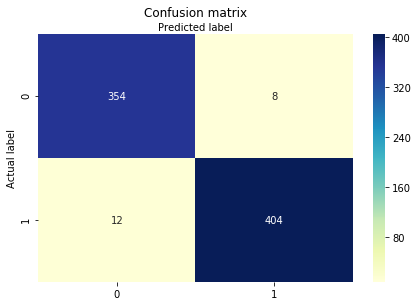

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cfs[0]), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [274]:
#model 4 include xp and gold advantage
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics
import statistics as stats


col_names = list(rdf.columns)
col_names = ['radiant_gold_adv', 'radiant_xp_adv']
X = rdf[col_names]
y = rdf['radiant_win']

#normalize X values
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y= y.to_numpy()


mses = []
cfs =[]
accuracy = []

cv = KFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_true = X_test
    
    mse = np.square(np.subtract(y_test,y_pred)).mean()
    mses.append(mse)
    
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cfs.append(cnf_matrix)
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    

print("Average MSE for Model 4: ", stats.mean(mses))
print("Average accuracy for Model 4: ",stats.mean(accuracy))

Average MSE for Model 4:  0.022381580993406185
Average accuracy for Model 4:  0.9776184190065939


C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Text(0.5, 257.44, 'Predicted label')

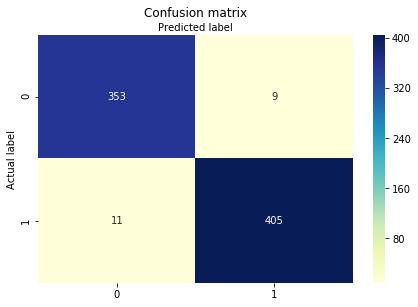

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cfs[0]), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [256]:
rdf.columns

Index(['radiant_win', 'duration', 'first_blood_time', 'human_players',
       'radiant_gold_adv', 'radiant_xp_adv', 'teamfights',
       'radiant_ancient_bottom', 'radiant_ancient_top', 'radiant_bot_tier3',
       'radiant_bot_tier2', 'radiant_bot_tier1', 'radiant_mid_tier3',
       'radiant_mid_tier2', 'radiant_mid_tier1', 'radiant_top_tier3',
       'radiant_top_tier2', 'radiant_top_tier1', 'dire_ancient_bottom',
       'dire_ancient_top', 'dire_bot_tier3', 'dire_bot_tier2',
       'dire_bot_tier1', 'dire_mid_tier3', 'dire_mid_tier2', 'dire_mid_tier1',
       'dire_top_tier3', 'dire_top_tier2', 'dire_top_tier1', 'dire_bot_ranged',
       'dire_bot_melee', 'dire_mid_ranged', 'dire_mid_melee',
       'dire_top_ranged', 'dire_top_melee', 'radiant_bot_ranged',
       'radiant_bot_melee', 'radiant_mid_ranged', 'radiant_mid_melee',
       'radiant_top_ranged', 'radiant_top_melee'],
      dtype='object')

In [113]:
rdf['radiant_win'].value_counts()

1    2032
0    1855
Name: radiant_win, dtype: int64

C:\Users\aegis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


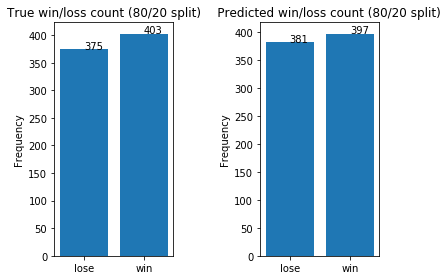

In [276]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

col_names = list(rdf.columns)
col_names.remove('radiant_win')
#col_names = ['radiant_ancient_top', 'dire_ancient_top']
#col_names.remove('duration')
#col_names.remove('first_blood_time')
#col_names.remove('human_players')
#col_names.remove('radiant_gold_adv')
#col_names.remove('radiant_xp_adv')
#col_names.remove('teamfights')
X = rdf[col_names]
y = rdf['radiant_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=15)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

unique, counts_test = np.unique(y_test, return_counts=True)
unique, counts_pred = np.unique(y_pred, return_counts=True)
unique = [0,1]

        
plt.subplot(1, 2, 1)
x1 = ['lose','win']
y1 = counts_test
plt.bar(x1, y1, align='center')
plt.ylabel('Frequency')
plt.title('True win/loss count (80/20 split)     ')
for a,b in zip(x1, y1):
    plt.text(a, b, str(b))


plt.subplot(1, 2, 2)
x2 = ['lose','win']
y2 = counts_pred
plt.bar(x2, y2, align='center')
plt.ylabel('Frequency')
plt.title('     Predicted win/loss count (80/20 split)')
for a,b in zip(x2, y2):
    plt.text(a, b, str(b))


plt.tight_layout()

plt.show()

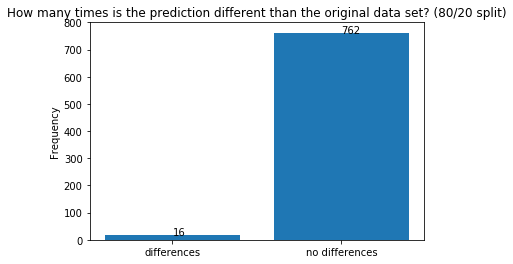

In [277]:
count_same = 0
count_diff = 0
y_test1 = y_test.array

for i in range(0,len(y_pred)):
    if y_pred[i] == y_test1[i]:
        count_same = count_same + 1
    else:
        count_diff = count_diff + 1

plt.subplot(1, 1, 1)
unique = ['differences', 'no differences' ]
counts = [count_diff, count_same]
plt.bar(unique, counts, align='center')
plt.ylabel('Frequency')
plt.title('How many times is the prediction different than the original data set? (80/20 split)')
for a,b in zip(unique, counts):
    plt.text(a, b, str(b))
    
plt.show()

Text(0.5, 257.44, 'Predicted label')

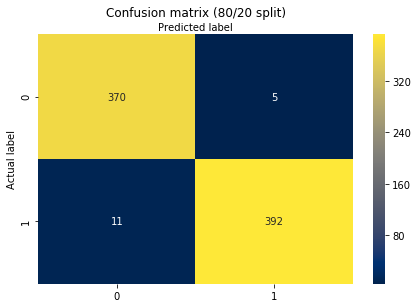

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
accuracy.append(metrics.accuracy_score(y_test, y_pred))


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="cividis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix (80/20 split)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

<function matplotlib.pyplot.show(*args, **kw)>

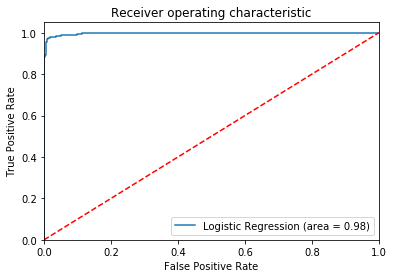

In [279]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show

In [281]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       375
           1       0.99      0.97      0.98       403

    accuracy                           0.98       778
   macro avg       0.98      0.98      0.98       778
weighted avg       0.98      0.98      0.98       778

